In [1]:
import os
import sys

# Navigate to the parent directory of the project structure
project_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
src_dir = os.path.join(project_dir, 'src')
fig_dir = os.path.join(project_dir, 'fig')
data_dir = os.path.join(project_dir, 'data')
log_dir = os.path.join(project_dir, 'log')
os.makedirs(fig_dir, exist_ok=True)

# Add the src directory to sys.path
sys.path.append(src_dir)

import mech.full_DPSGD as DPSGDModule
from estimator.ptlr import KDE_Estimator_from_samples
from analysis.tradeoff_Gaussian import Gaussian_curve

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- File paths ---~/Documents/R/f-DP/revis
group_d_path = os.path.expanduser(os.path.join(data_dir, "logits_d.csv"))
group_dprime_path = os.path.expanduser(os.path.join(data_dir, "logits_dprime.csv"))

# --- Load class 0 (airplane) scores ---
p = pd.read_csv(group_d_path)["logit_0"].values
q = pd.read_csv(group_dprime_path)["logit_0"].values

# --- KDE Estimation ---
eta_max = 15
h = 0.1

output_df = KDE_Estimator_from_samples(eta_max, h, p, q)

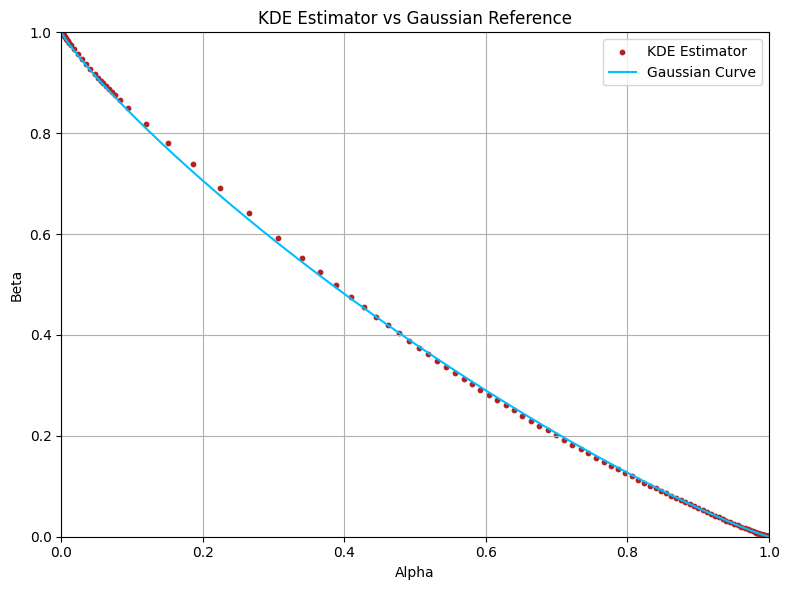

In [4]:
# Plot the results
alpha_list = output_df["alpha"]
beta_list = output_df["beta"]

plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, beta_list, color="firebrick", s=10, label="KDE Estimator")

# Plot Gaussian reference curve
alpha_values = np.linspace(1e-6, 1 - 1e-6, 1000)  # avoid ppf(0) or ppf(1) for safety
gaussian_values = Gaussian_curve(alpha_values, mean_difference = 0.3)
plt.plot(alpha_values, gaussian_values, color="deepskyblue", linewidth=1.5, label="Gaussian Curve")

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.title("KDE Estimator vs Gaussian Reference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
from classifier.kNN import train_kNN_model
from utils.utils import _ensure_2dim, DUMMY_CONSTANT
import time

# --- Load class 0 (airplane) scores ---
p_arr = pd.read_csv(group_d_path)["logit_0"].values
q_arr = pd.read_csv(group_dprime_path)["logit_0"].values

# train_sample_size = 9000
# test_sample_size = len(p_arr) - train_sample_size
# p_train, q_train = _ensure_2dim(p_arr[:train_sample_size], q_arr[:train_sample_size])
# p_test, q_test = _ensure_2dim(p_arr[-test_sample_size:], q_arr[-test_sample_size:])

train_sample_size = len(p_arr)
test_sample_size = len(p_arr)
p_train, q_train = _ensure_2dim(p_arr[:train_sample_size], q_arr[:train_sample_size])
p_test, q_test = _ensure_2dim(p_arr[:train_sample_size], q_arr[:train_sample_size])


def adjust_samples(p_arr, q_arr, eta = 1):
    num_samples = len(p_arr)
    bot = -DUMMY_CONSTANT

    if eta == 1:
        return p_arr, q_arr
    
    if eta > 1:
        p = np.random.uniform(0, 1, num_samples) > (1.0/eta)
        p = p.reshape((num_samples, 1)) * np.ones((num_samples, 1))
        p_arr = (1-p)*p_arr + p*(bot*np.ones_like(1))
    elif eta < 1:
        p = np.random.uniform(0, 1, num_samples) > eta
        p = p.reshape((num_samples, 1)) * np.ones((num_samples, 1))
        q_arr = (1-p)*q_arr + p*(bot*np.ones_like(1))
    
    return p_arr, q_arr

# Example usage:
def compute_kNN_alpha_beta(eta_list, p_train, q_train, p_test, q_test):
    alpha_list = []
    beta_list = []
    
    for eta in eta_list:
        adjusted_p_train, adjusted_q_train = adjust_samples(p_train, q_train, eta)
        adjusted_p_test, adjusted_q_test = adjust_samples(p_test, q_test, eta)

        train_samples = np.vstack((adjusted_p_train, adjusted_q_train))
        train_labels = np.concatenate((np.zeros(len(adjusted_p_train)), np.ones(len(adjusted_q_train))))
        model = train_kNN_model({'X': train_samples, 'y': train_labels})

        test_samples = np.vstack((adjusted_p_test, adjusted_q_test))
        test_labels = np.concatenate((np.zeros(len(adjusted_p_test)), np.ones(len(adjusted_q_test))))

        start_time = time.time()
        alpha = 1 - model.score(test_samples[:test_sample_size], test_labels[:test_sample_size])
        beta = 1 - model.score(test_samples[test_sample_size:], test_labels[test_sample_size:])
        print(f"(alpha, beta) w.r.t {eta} is ({alpha}, {beta}) [Computation time is {time.time() - start_time:.2f}]")
        
        alpha_list.append(alpha)
        beta_list.append(beta)
    
    return alpha_list, beta_list

# Example usage:    
# eta_list = [0.93, 0.95, 1.0]
# alpha_beta_results = compute_kNN_alpha_beta(eta_list, p_train, q_train, p_test, q_test)

(alpha, beta) w.r.t 0.7 is (0.021372328458942658, 0.6749156355455568) [Computation time is 0.04]
(alpha, beta) w.r.t 0.75 is (0.10236220472440949, 0.5905511811023623) [Computation time is 0.04]
(alpha, beta) w.r.t 0.8 is (0.1901012373453318, 0.5736782902137233) [Computation time is 0.04]
(alpha, beta) w.r.t 0.85 is (0.2440944881889764, 0.5545556805399325) [Computation time is 0.04]
(alpha, beta) w.r.t 0.9 is (0.45106861642294716, 0.3734533183352081) [Computation time is 0.04]
(alpha, beta) w.r.t 0.95 is (0.4701912260967379, 0.3925759280089989) [Computation time is 0.04]
(alpha, beta) w.r.t 1.0 is (0.4870641169853769, 0.3790776152980877) [Computation time is 0.04]
(alpha, beta) w.r.t 1.05 is (0.547806524184477, 0.3408323959505062) [Computation time is 0.04]
(alpha, beta) w.r.t 1.1 is (0.5286839145106861, 0.2767154105736783) [Computation time is 0.04]
(alpha, beta) w.r.t 1.15 is (0.5365579302587177, 0.26096737907761525) [Computation time is 0.04]
(alpha, beta) w.r.t 1.2 is (0.50956130483

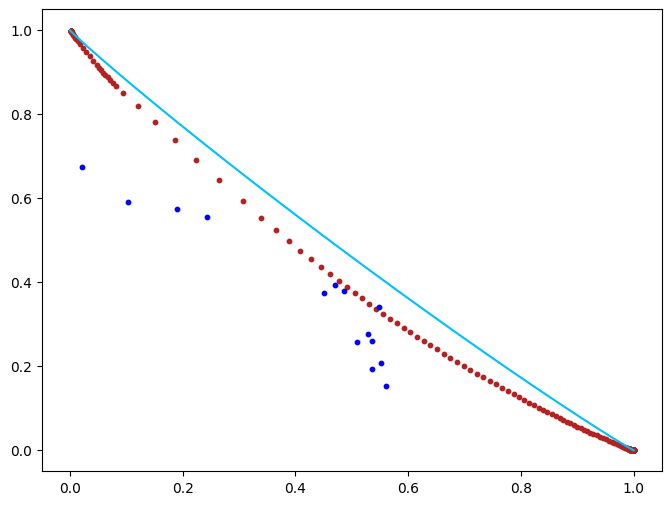

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, beta_list, color="firebrick", s=10, label="KDE Estimator")

eta_list = [round(x, 2) for x in np.arange(0.8, 1.25, 0.02)]
alpha_kNN, beta_kNN = compute_kNN_alpha_beta(eta_list, p_train, q_train, p_test, q_test)

plt.scatter(alpha_kNN, beta_kNN, color="blue", s=10, label="kNN Estimator")

# Plot Gaussian reference curve
alpha_values = np.linspace(1e-6, 1 - 1e-6, 1000)  # avoid ppf(0) or ppf(1) for safety
gaussian_values = Gaussian_curve(alpha_values)
plt.plot(alpha_values, gaussian_values, color="deepskyblue", linewidth=1.5, label="Gaussian Curve")

In [21]:
eta_list

[0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35]